# Binary classification on an imbalanced dataset (Breast Cancer detection) 

In this notebook I will demonstrate how to classify a highly imbalanced dataset in which the number of examples in one class greatly outnumbers the examples in another. I will be working with data collected from the Breast Cancer Surveillance Consortium (BCSC). The goal is to detect 259 positive breast cancer cases from a total of 40000 mammogram screening.

The notebook is based on the "Classification on imbalanced data" turtorial on: 
- https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
- https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/imbalanced_data.ipynb

## Setup

Import the required packages.

In [244]:
import os
import tempfile
import pandas as pd
import numpy as np

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [245]:
#Create a function to plot confusion matrix

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

## Importing the data

Next, I will be using data collect from the Breast Cancer Surveillance Consortium (BCSC). This digital mammography dataset includes information from 20,000 digital and 20,000 film screening mammograms performed between January 2005 and December 2008 from women included in the Breast Cancer Surveillance Consortium. Some women contributed more than one examination to the dataset.

Data collection and sharing was supported by the National Cancer Institute-funded Breast Cancer Surveillance Consortium (HHSN261201100031C). You can learn more about the BCSC at: http://www.bcsc-research.org/.

The variables in the dataset are defined as so:

In [246]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('max_colwidth', 99)

var_table = [

["age_c","patient's age in years at time of mammogram","Numerical"],

["assess_c","Radiologist's assessment based on the BI-RADS scale",["0 = Needs additional imaging",
"1 = Negative",
"2 = Benign finding(s)",
"3 = Probably benign",
"4 = Suspicious abnormality",
"5 = Highly suggestive of malignancy"]],

["cancer_c","binary indicator of cancer diagnosis within one year of screening mammogram",["0 = no cancer diagnosis",
"1 = cancer diagnosis"]],

["compfilm_c","comparison mammogram from prior mammography examination available",["0 = no",
"1 = yes",
"9 = missing"]],
    
["density_c","patient's BI-RADS breast density as recorded at time of mammogram",["1 = Almost entirely fatty",
"2 = Scattered fibroglandular densities",
"3 = Heterogeneously dense",
"4 = Extremely dense"]],
    
["famhx_c","family history of breast cancer in a first degree relative",
["0 = no",
"1 = yes",
"9 = missing"]],
    
["hrt_c","current use of hormone therapy at time of mammogram", 
["0 = no",
"1 = yes",
"9 = missing"]],
    
["prvmam_c","binary indicator of whether the woman had ever received a prior mammogram",
["0 = no",
"1 = yes",
"9 = missing"]],
    
["biophx_c","history of breast biopsy",
["0 = no",
"1 = yes",
"9 = missing"]],
    
["mammtype","film or digital mammogram",    
["1 = film mammogram",
"2 = digital mammogram"]],
    
["CaTypeO","cancer type",
["1 = ductal carcinoma in situ",
"2 = invasive cancer",
"8 = no cancer diagnosis"]],
    
["bmi_c","body mass index at time of mammogram","Numerical or -99 if missing"],
    
["ptid","patient's study id",""]
 
]

tdf = pd.DataFrame(var_table,columns = ["Variable Name","Description","coding"])
tdf

,Variable Name,Description,coding
0,age_c,patient's age in years at time of mammogram,Numerical
1,assess_c,Radiologist's assessment based on the BI-RADS scale,"[0 = Needs additional imaging, 1 = Negative, 2 = Benign finding(s), 3 = Probably benign, 4 = Su..."
2,cancer_c,binary indicator of cancer diagnosis within one year of screening mammogram,"[0 = no cancer diagnosis, 1 = cancer diagnosis]"
3,compfilm_c,comparison mammogram from prior mammography examination available,"[0 = no, 1 = yes, 9 = missing]"
4,density_c,patient's BI-RADS breast density as recorded at time of mammogram,"[1 = Almost entirely fatty, 2 = Scattered fibroglandular densities, 3 = Heterogeneously dense, ..."
5,famhx_c,family history of breast cancer in a first degree relative,"[0 = no, 1 = yes, 9 = missing]"
6,hrt_c,current use of hormone therapy at time of mammogram,"[0 = no, 1 = yes, 9 = missing]"
7,prvmam_c,binary indicator of whether the woman had ever received a prior mammogram,"[0 = no, 1 = yes, 9 = missing]"
8,biophx_c,history of breast biopsy,"[0 = no, 1 = yes, 9 = missing]"
9,mammtype,film or digital mammogram,"[1 = film mammogram, 2 = digital mammogram]"


In [247]:
#Import in the data
df = pd.read_csv('dataset.csv')

#Set the correct column names
df = df[['age_c','assess_c','compfilm_c','density_c','famhx_c',
         'hrt_c','prvmam_c','biophx_c','mammtype','CaTypeO','bmi_c',
         'ptid','cancer_c',]]

df.head()

,age_c,assess_c,compfilm_c,density_c,famhx_c,hrt_c,prvmam_c,biophx_c,mammtype,CaTypeO,bmi_c,ptid,cancer_c
0,62,1,1,2,0,0,1,0,1,8,24.023544,1,0
1,65,1,1,4,0,0,1,0,1,8,-99.000000,2,0
2,69,0,1,2,0,0,1,0,1,8,29.052429,3,0
3,64,2,1,2,0,0,1,0,1,8,-99.000000,4,0
4,63,3,1,2,0,0,1,1,1,8,33.729523,5,0


## Exploratory Data Analysis

In [248]:
#Find the shape of the dataset
df.shape

(40000, 13)

In [249]:
#Check dataframe
df.describe()

,age_c,assess_c,compfilm_c,density_c,famhx_c,hrt_c,prvmam_c,biophx_c,mammtype,CaTypeO,bmi_c,ptid,cancer_c
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,69.555850,1.203450,1.903450,2.229725,0.219875,0.504925,1.108200,0.444675,1.500000,7.959750,-46.164809,18376.250225,0.006475
std,7.202974,0.575775,2.589304,0.716355,0.762853,1.854633,0.959435,1.309191,0.500006,0.499686,62.225752,10601.991024,0.080207
min,60.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,-99.000000,1.000000,0.000000
25%,63.000000,1.000000,1.000000,2.000000,0.000000,0.000000,1.000000,0.000000,1.000000,8.000000,-99.000000,9202.750000,0.000000
50%,68.000000,1.000000,1.000000,2.000000,0.000000,0.000000,1.000000,0.000000,1.500000,8.000000,-99.000000,18392.500000,0.000000
75%,75.000000,2.000000,1.000000,3.000000,0.000000,0.000000,1.000000,1.000000,2.000000,8.000000,24.691544,27562.250000,0.000000
max,89.000000,5.000000,9.000000,4.000000,9.000000,9.000000,9.000000,9.000000,2.000000,8.000000,71.721314,36714.000000,1.000000


In [250]:
#There are no missing entries
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age_c       40000 non-null  int64  
 1   assess_c    40000 non-null  int64  
 2   compfilm_c  40000 non-null  int64  
 3   density_c   40000 non-null  int64  
 4   famhx_c     40000 non-null  int64  
 5   hrt_c       40000 non-null  int64  
 6   prvmam_c    40000 non-null  int64  
 7   biophx_c    40000 non-null  int64  
 8   mammtype    40000 non-null  int64  
 9   CaTypeO     40000 non-null  int64  
 10  bmi_c       40000 non-null  float64
 11  ptid        40000 non-null  int64  
 12  cancer_c    40000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 4.0 MB


In [251]:
#Check how many positives and negatives in the dataset
df['cancer_c'].value_counts()

0    39741
1      259
Name: cancer_c, dtype: int64

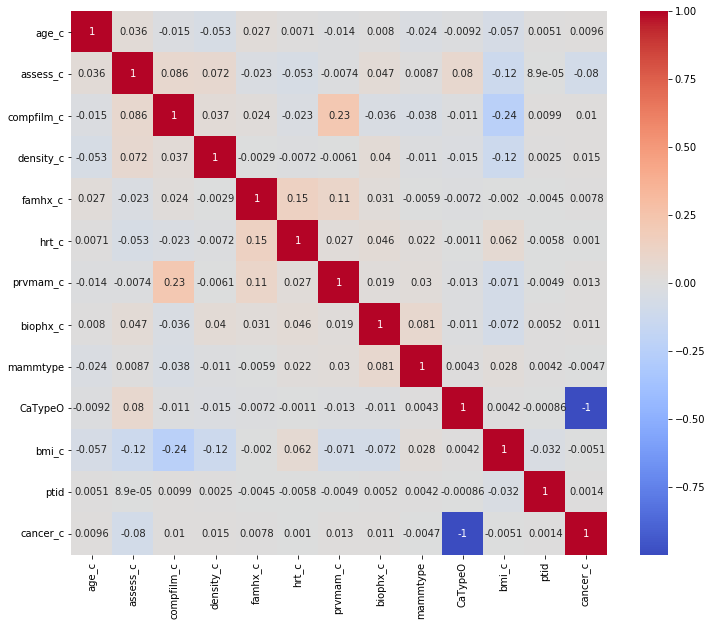

In [252]:
#Lets take a look at how each variable correlated with each other
Var_Corr = df.corr()
#plot the heatmap and annotate it
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True, cmap='coolwarm')

## Data Processing

To prevent any variable from gaining too much inflience in the overall prediction, I am going to normalize all the variables in the dataset. 

In [253]:
normalized_df=(df-df.mean())/df.std()
ndf = normalized_df
#Print out dataframe to check output
ndf.head()

,age_c,assess_c,compfilm_c,density_c,famhx_c,hrt_c,prvmam_c,biophx_c,mammtype,CaTypeO,bmi_c,ptid,cancer_c
0,-1.048990,-0.353350,-0.348916,-0.320686,-0.288227,-0.272251,-0.112775,-0.339656,-0.999987,0.080551,1.127963,-1.733189,-0.080728
1,-0.632496,-0.353350,-0.348916,2.471226,-0.288227,-0.272251,-0.112775,-0.339656,-0.999987,0.080551,-0.849089,-1.733094,-0.080728
2,-0.077170,-2.090141,-0.348916,-0.320686,-0.288227,-0.272251,-0.112775,-0.339656,-0.999987,0.080551,1.208780,-1.733000,-0.080728
3,-0.771327,1.383441,-0.348916,-0.320686,-0.288227,-0.272251,-0.112775,-0.339656,-0.999987,0.080551,-0.849089,-1.732906,-0.080728
4,-0.910159,3.120231,-0.348916,-0.320686,-0.288227,-0.272251,-0.112775,0.424174,-0.999987,0.080551,1.283943,-1.732811,-0.080728


In [254]:
#Check dataframe shape
ndf.shape

(40000, 13)

In [255]:
#Check dataframe
ndf.describe()

,age_c,assess_c,compfilm_c,density_c,famhx_c,hrt_c,prvmam_c,biophx_c,mammtype,CaTypeO,bmi_c,ptid,cancer_c
count,4.000000e+04,4.000000e+04,4.000000e+04,4.000000e+04,4.000000e+04,4.000000e+04,4.000000e+04,4.000000e+04,4.000000e+04,4.000000e+04,4.000000e+04,4.000000e+04,4.000000e+04
mean,-6.730394e-16,7.451345e-16,-3.626238e-16,-7.276069e-16,2.246622e-15,-2.484266e-15,7.357046e-16,2.690459e-16,6.106227e-19,8.437563e-16,-2.021981e-14,7.104928e-16,6.411927e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.326653e+00,-2.090141e+00,-7.351203e-01,-1.716642e+00,-2.882273e-01,-2.722507e-01,-1.155055e+00,-3.396562e-01,-9.999875e-01,-1.392824e+01,-8.490888e-01,-1.733189e+00,-8.072816e-02
25%,-9.101588e-01,-3.533501e-01,-3.489161e-01,-3.206860e-01,-2.882273e-01,-2.722507e-01,-1.127747e-01,-3.396562e-01,-9.999875e-01,8.055057e-02,-8.490888e-01,-8.652620e-01,-8.072816e-02
50%,-2.160011e-01,-3.533501e-01,-3.489161e-01,-3.206860e-01,-2.882273e-01,-2.722507e-01,-1.127747e-01,-3.396562e-01,0.000000e+00,8.055057e-02,-8.490888e-01,1.532710e-03,-8.072816e-02
75%,7.558198e-01,1.383441e+00,-3.489161e-01,1.075270e+00,-2.882273e-01,-2.722507e-01,-1.127747e-01,4.241741e-01,9.999875e-01,8.055057e-02,1.138698e+00,8.664410e-01,-8.072816e-02
max,2.699462e+00,6.593813e+00,2.740717e+00,2.471226e+00,1.150959e+01,4.580463e+00,8.225465e+00,6.534816e+00,9.999875e-01,8.055057e-02,1.894491e+00,1.729652e+00,1.238694e+01


In [256]:
#check for missing entries
ndf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age_c       40000 non-null  float64
 1   assess_c    40000 non-null  float64
 2   compfilm_c  40000 non-null  float64
 3   density_c   40000 non-null  float64
 4   famhx_c     40000 non-null  float64
 5   hrt_c       40000 non-null  float64
 6   prvmam_c    40000 non-null  float64
 7   biophx_c    40000 non-null  float64
 8   mammtype    40000 non-null  float64
 9   CaTypeO     40000 non-null  float64
 10  bmi_c       40000 non-null  float64
 11  ptid        40000 non-null  float64
 12  cancer_c    40000 non-null  float64
dtypes: float64(13)
memory usage: 4.0 MB


In [257]:
#Change column name 'cancer_c' to 'cancer' for easier excution
ndf['cancer'] = df['cancer_c']
ndf = ndf.drop(columns = ['cancer_c'])

In [258]:
#Check number of positives and negatives again
ndf.cancer.value_counts()

0    39741
1      259
Name: cancer, dtype: int64

In [259]:
#Shuffle dataframe rows(sample all without replacement)
ndf = ndf.sample(frac=1).reset_index(drop=True)
ndf

,age_c,assess_c,compfilm_c,density_c,famhx_c,hrt_c,prvmam_c,biophx_c,mammtype,CaTypeO,bmi_c,ptid,cancer
0,2.144135,-0.353350,-0.348916,1.075270,-0.288227,-0.272251,-0.112775,-0.339656,0.999987,0.080551,-0.849089,0.514125,0
1,-0.910159,-0.353350,-0.348916,-0.320686,-0.288227,-0.272251,-0.112775,-0.339656,-0.999987,0.080551,-0.849089,1.562419,0
2,-0.493664,-0.353350,-0.348916,2.471226,1.022641,-0.272251,-0.112775,-0.339656,-0.999987,0.080551,-0.849089,-1.631132,0
3,1.172314,-0.353350,-0.348916,1.075270,-0.288227,0.266940,-0.112775,-0.339656,-0.999987,0.080551,-0.849089,-0.306004,0
4,-0.632496,-2.090141,-0.348916,-0.320686,-0.288227,-0.272251,-0.112775,-0.339656,-0.999987,0.080551,-0.849089,-0.889762,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,-0.632496,1.383441,2.740717,-1.716642,-0.288227,-0.272251,-0.112775,-0.339656,0.999987,0.080551,-0.849089,-1.616795,0
39996,-1.326653,-0.353350,-0.348916,-0.320686,-0.288227,-0.272251,-0.112775,-0.339656,0.999987,0.080551,1.285663,-0.408060,0
39997,1.033483,1.383441,-0.348916,1.075270,-0.288227,-0.272251,-0.112775,0.424174,-0.999987,0.080551,-0.849089,-0.177632,0
39998,1.311146,-0.353350,2.740717,1.075270,-0.288227,-0.272251,-0.112775,-0.339656,-0.999987,0.080551,-0.849089,-0.242148,0


In [260]:
#Assign variables to X and labels to y and convert to arrays
X = ndf.iloc[:,:-1].values
y = ndf.iloc[:,-1].values

print(X)
print(y)

[[ 2.14413532 -0.35335008 -0.34891614 ...  0.08055057 -0.84908884
   0.51412511]
 [-0.91015883 -0.35335008 -0.34891614 ...  0.08055057 -0.84908884
   1.56241877]
 [-0.49366418 -0.35335008 -0.34891614 ...  0.08055057 -0.84908884
  -1.63113232]
 ...
 [ 1.0334829   1.38344068 -0.34891614 ...  0.08055057 -0.84908884
  -0.17763175]
 [ 1.31114601 -0.35335008  2.74071709 ...  0.08055057 -0.84908884
  -0.24214793]
 [-1.04899039 -0.35335008 -0.34891614 ...  0.08055057  1.22462408
  -0.12179318]]
[0 0 0 ... 0 0 0]


In [261]:
#Split the dataset to 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=True, test_size = 0.2)

#Check output shape 
print('X_train',X_train.shape)
print('y_train',y_train.shape)
print('X_test',X_test.shape)
print('y_test',y_test.shape)

#Clip data to get rid out outliers(Anything over 5std)
train_features = np.clip(X_train, -5, 5)
test_features = np.clip(X_test, -5, 5)
train_labels = y_train
test_labels = y_test

X_train (32000, 12)
y_train (32000,)
X_test (8000, 12)
y_test (8000,)


In [262]:
#Define confusion matrix metrics
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

#Create a funtion to create the neural network model
def make_model(metrics = METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

#Define the hyperparameters of the model
EPOCHS = 100
BATCH_SIZE = 2048

#Define early stopping criteria, I will be using AUC as the metric. 
#If the AUC doesnt improve after 10 epocs, it will stop training.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [263]:
#Show model summary
model = make_model()
model.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_78 (Dense)             (None, 16)                208       
_________________________________________________________________
dropout_39 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_79 (Dense)             (None, 1)                 17        
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________


## Test model without optimizations

To see how well the model predicts, I am going to test the model before any training and optimizations.

In [264]:
#make prediction with bias = 0
model.predict(train_features[:10])

array([[0.03537288],
       [0.07821113],
       [0.171756  ],
       [0.22946891],
       [0.17679116],
       [0.05780935],
       [0.11025295],
       [0.12557638],
       [0.05920811],
       [0.07844544]], dtype=float32)

As we can see, it predicted mostly positives for the first 10 predictions. Now lets take a look at how well it predicts on the test dataset.

loss :  0.15063159418106079
tp :  0.0
fp :  16.0
tn :  7934.0
fn :  50.0
accuracy :  0.99175
precision :  0.0
recall :  0.0
auc :  0.1602629

Legitimate Transactions Detected (True Negatives):  7934
Legitimate Transactions Incorrectly Detected (False Positives):  16
Fraudulent Transactions Missed (False Negatives):  50
Fraudulent Transactions Detected (True Positives):  0
Total Fraudulent Transactions:  50


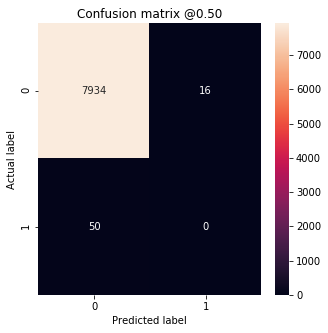

In [265]:
#Evaluate model
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

Judging from the comfusion matrix, there seems to be alot of false positives. Lets see if we can impriove the predictions.

## Using the optimal bias

The initial predictions were not great as the data is imbalanced. To improve the predictions, I am going to adjust the bias to reflect the unbalanced nature of the dataset. This will help with initial convergence.

In [266]:
#Find how many positive and negative
neg, pos = np.bincount(ndf['cancer'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 40000
    Positive: 259 (0.65% of total)



In [267]:
#create the optimal bias
initial_bias = np.log([pos/neg])
initial_bias

array([-5.03331062])

In [268]:
#make prediction with new bias
model = make_model(output_bias = initial_bias)
model.predict(train_features[:10])

array([[0.06865048],
       [0.01792511],
       [0.01213306],
       [0.00819212],
       [0.007532  ],
       [0.00920063],
       [0.00659376],
       [0.00571695],
       [0.01646033],
       [0.0057539 ]], dtype=float32)

The new predictions are mostly negative now.

In [269]:
#Print the loss with original bias
og_model = make_model(output_bias = 0)
og_results = og_model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(og_results[0]))

Loss: 0.9403


In [270]:
#Print the loss with the new bias
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0493


In [271]:
fnum = int(round(og_results[0]/results[0]))

print('With the new bias, the loss improved by a factor of {}.'.format(fnum))

With the new bias, the loss improved by a factor of 19.


loss :  0.047733722448348996
tp :  0.0
fp :  0.0
tn :  7950.0
fn :  50.0
accuracy :  0.99375
precision :  0.0
recall :  0.0
auc :  0.17829685

Legitimate Transactions Detected (True Negatives):  7950
Legitimate Transactions Incorrectly Detected (False Positives):  0
Fraudulent Transactions Missed (False Negatives):  50
Fraudulent Transactions Detected (True Positives):  0
Total Fraudulent Transactions:  50


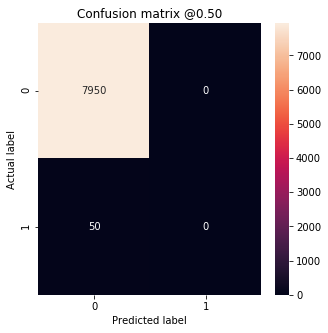

In [272]:
#Evaluate model
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

As we can see the model prediction for false positives has improved but the true negatives has gotten worse.

## Ploting the convergence of model with new bias

In [273]:
#Save the new bias weights
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

In [274]:
#Model with original bias
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20, 
    verbose=0)

In [275]:
#Model with optimized bias
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20, 
    verbose=0)

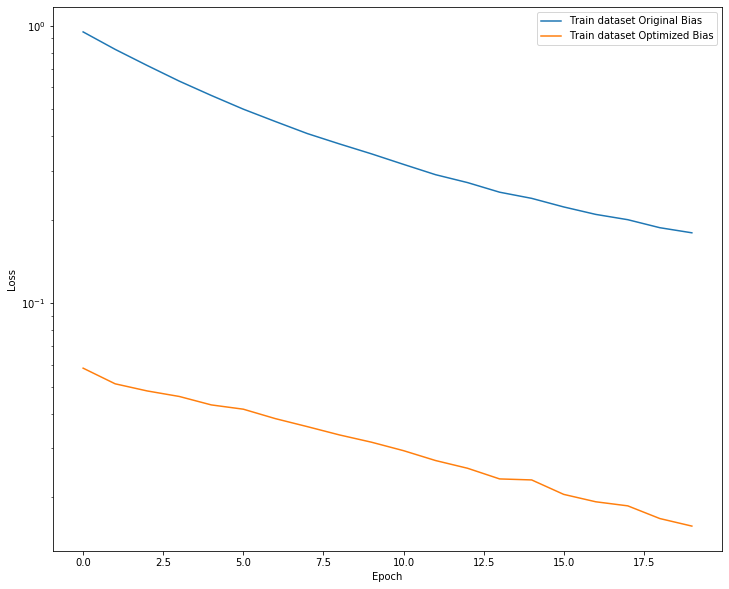

In [276]:
#Plot the line graphs
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train dataset '+label)
  #plt.semilogy(history.epoch,  history.history['val_loss'],
  #        color=colors[n], label='Val '+label,
  #        linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  
  plt.legend()

plot_loss(zero_bias_history, "Original Bias", 0)
plot_loss(careful_bias_history, "Optimized Bias", 1)

As we can see, with the bias optimization, the model started and ended in a better position(in terms of the loss) than the model without bias optimization. Next, lets train the model to see if we can improve the predictions.

## Train the model

In [277]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping])

Train on 32000 samples
Epoch 1/100
32000/32000 [==============================] - 1s 40us/sample - loss: 0.0572 - tp: 0.0000e+00 - fp: 75.0000 - tn: 31716.0000 - fn: 209.0000 - accuracy: 0.9911 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.3751
Epoch 2/100
32000/32000 [==============================] - 0s 3us/sample - loss: 0.0529 - tp: 0.0000e+00 - fp: 41.0000 - tn: 31750.0000 - fn: 209.0000 - accuracy: 0.9922 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.3892
Epoch 3/100
32000/32000 [==============================] - 0s 3us/sample - loss: 0.0472 - tp: 0.0000e+00 - fp: 23.0000 - tn: 31768.0000 - fn: 209.0000 - accuracy: 0.9927 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4567
Epoch 4/100
32000/32000 [==============================] - 0s 3us/sample - loss: 0.0455 - tp: 1.0000 - fp: 21.0000 - tn: 31770.0000 - fn: 208.0000 - accuracy: 0.9928 - precision: 0.0455 - recall: 0.0048 - auc: 0.4952    
Epoch 5/100
32000/32000 [==============================] - 0s 3us/sa

32000/32000 [==============================] - 0s 3us/sample - loss: 0.0057 - tp: 169.0000 - fp: 1.0000 - tn: 31790.0000 - fn: 40.0000 - accuracy: 0.9987 - precision: 0.9941 - recall: 0.8086 - auc: 0.9965
Epoch 38/100
32000/32000 [==============================] - 0s 3us/sample - loss: 0.0059 - tp: 167.0000 - fp: 0.0000e+00 - tn: 31791.0000 - fn: 42.0000 - accuracy: 0.9987 - precision: 1.0000 - recall: 0.7990 - auc: 0.9987
Epoch 39/100
32000/32000 [==============================] - 0s 3us/sample - loss: 0.0054 - tp: 171.0000 - fp: 1.0000 - tn: 31790.0000 - fn: 38.0000 - accuracy: 0.9988 - precision: 0.9942 - recall: 0.8182 - auc: 0.9941
Epoch 40/100
32000/32000 [==============================] - 0s 3us/sample - loss: 0.0058 - tp: 169.0000 - fp: 0.0000e+00 - tn: 31791.0000 - fn: 40.0000 - accuracy: 0.9987 - precision: 1.0000 - recall: 0.8086 - auc: 0.9933
Epoch 41/100
32000/32000 [==============================] - 0s 3us/sample - loss: 0.0053 - tp: 171.0000 - fp: 0.0000e+00 - tn: 31791.

loss :  0.0010720726577565073
tp :  50.0
fp :  0.0
tn :  7950.0
fn :  0.0
accuracy :  1.0
precision :  1.0
recall :  1.0
auc :  1.0

Legitimate Transactions Detected (True Negatives):  7950
Legitimate Transactions Incorrectly Detected (False Positives):  0
Fraudulent Transactions Missed (False Negatives):  0
Fraudulent Transactions Detected (True Positives):  50
Total Fraudulent Transactions:  50


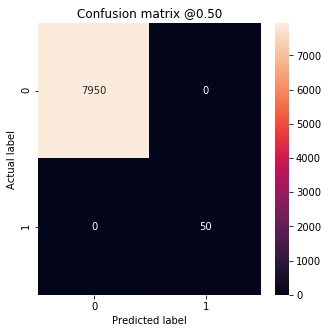

In [278]:
#Evaluate model
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

After the training the model got the correct predictions on the test dataset. Next, lets test the model on the whole dataset.

## Test model on the whole dataset

loss :  0.0009000805385410785
tp :  259.0
fp :  0.0
tn :  39741.0
fn :  0.0
accuracy :  1.0
precision :  1.0
recall :  1.0
auc :  1.0

Legitimate Transactions Detected (True Negatives):  39741
Legitimate Transactions Incorrectly Detected (False Positives):  0
Fraudulent Transactions Missed (False Negatives):  0
Fraudulent Transactions Detected (True Positives):  259
Total Fraudulent Transactions:  259


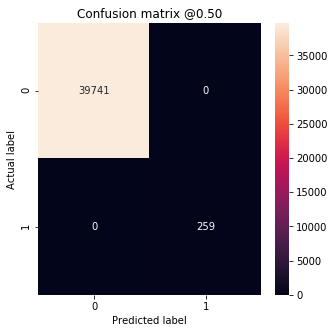

In [279]:
#Evaluate model with the total dataset

all_predictions_baseline = model.predict(X, batch_size=BATCH_SIZE)

baseline_results = model.evaluate(X, y,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y, all_predictions_baseline)

And there you have it! In the dataset there was 259 positive cases and 39741 negative cases. After adjusting the bias and training the model, the model has gotten good enough to predict all the postive results in the dataset. 

Imbalanced data classification is an inherantly difficult task since there are so few samples to learn from. You should always start with the data first and do your best to collect as many samples as possible and give substantial thought to what features may be relevant so the model can get the most out of your minority class. At some point your model may struggle to improve and yield the results you want, so it is important to keep in mind the context of your problem and the trade offs between different types of errors.

## Optimal: Calculating Class weights and trian model

Had there still been trouble with model predicting on the dataset I would optimize the model by calulating the class weights and retraining the model to improve the predictions.

In [280]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 77.22


In [281]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    # The class weights go here
    class_weight=class_weight) 

  ...
    to  
  ['...']
Train on 32000 samples
Epoch 1/100
32000/32000 [==============================] - 1s 37us/sample - loss: 2.8546 - tp: 0.0000e+00 - fp: 115.0000 - tn: 31676.0000 - fn: 209.0000 - accuracy: 0.9899 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.3620
Epoch 2/100
32000/32000 [==============================] - 0s 3us/sample - loss: 2.6028 - tp: 1.0000 - fp: 149.0000 - tn: 31642.0000 - fn: 208.0000 - accuracy: 0.9888 - precision: 0.0067 - recall: 0.0048 - auc: 0.4297  
Epoch 3/100
32000/32000 [==============================] - 0s 3us/sample - loss: 2.3612 - tp: 2.0000 - fp: 231.0000 - tn: 31560.0000 - fn: 207.0000 - accuracy: 0.9863 - precision: 0.0086 - recall: 0.0096 - auc: 0.4676  
Epoch 4/100
32000/32000 [==============================] - 0s 3us/sample - loss: 2.1195 - tp: 5.0000 - fp: 303.0000 - tn: 31488.0000 - fn: 204.0000 - accuracy: 0.9842 - precision: 0.0162 - recall: 0.0239 - auc: 0.5358 
Epoch 5/100
32000/32000 [==============================] - 0s 

32000/32000 [==============================] - 0s 3us/sample - loss: 0.1785 - tp: 190.0000 - fp: 1125.0000 - tn: 30666.0000 - fn: 19.0000 - accuracy: 0.9643 - precision: 0.1445 - recall: 0.9091 - auc: 0.9775
Epoch 38/100
32000/32000 [==============================] - 0s 2us/sample - loss: 0.2368 - tp: 181.0000 - fp: 1046.0000 - tn: 30745.0000 - fn: 28.0000 - accuracy: 0.9664 - precision: 0.1475 - recall: 0.8660 - auc: 0.9666
Epoch 39/100
32000/32000 [==============================] - 0s 2us/sample - loss: 0.2056 - tp: 184.0000 - fp: 1028.0000 - tn: 30763.0000 - fn: 25.0000 - accuracy: 0.9671 - precision: 0.1518 - recall: 0.8804 - auc: 0.9766
Epoch 40/100
32000/32000 [==============================] - 0s 2us/sample - loss: 0.1341 - tp: 193.0000 - fp: 959.0000 - tn: 30832.0000 - fn: 16.0000 - accuracy: 0.9695 - precision: 0.1675 - recall: 0.9234 - auc: 0.9889
Epoch 41/100
32000/32000 [==============================] - 0s 2us/sample - loss: 0.2104 - tp: 186.0000 - fp: 958.0000 - tn: 30833

loss :  0.016909409016370773
tp :  50.0
fp :  0.0
tn :  7950.0
fn :  0.0
accuracy :  1.0
precision :  1.0
recall :  1.0
auc :  1.0

Legitimate Transactions Detected (True Negatives):  7950
Legitimate Transactions Incorrectly Detected (False Positives):  0
Fraudulent Transactions Missed (False Negatives):  0
Fraudulent Transactions Detected (True Positives):  50
Total Fraudulent Transactions:  50


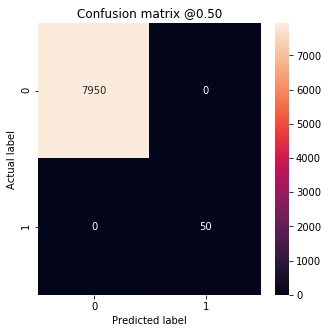

In [282]:
#Evaluate model
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

## Optional: Oversample and train model

Another way to optimize the model is by oversample the positive class in the dataset to improve the predictions.

In [283]:
bool_train_labels = train_labels != 0

pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

print(res_pos_features.shape)

resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

print(resampled_features.shape)

(31791, 12)
(63582, 12)


In [284]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [ 1.17231445 -2.09014084 -0.34891614  2.47122642 -0.28822726  0.26693968
 -0.11277469  0.42417405 -0.9999875  -5.         -0.84908884  1.6215586 ]

Label:  1


In [285]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.4912109375


In [286]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks = [early_stopping])

Train for 39.0 steps
Epoch 1/100
39/39 [==============================] - 3s 83ms/step - loss: 1.0432 - tp: 17506.0000 - fp: 23744.0000 - tn: 16174.0000 - fn: 22448.0000 - accuracy: 0.4217 - precision: 0.4244 - recall: 0.4382 - auc: 0.3919
Epoch 2/100
39/39 [==============================] - 2s 39ms/step - loss: 0.7835 - tp: 24281.0000 - fp: 19823.0000 - tn: 20047.0000 - fn: 15721.0000 - accuracy: 0.5550 - precision: 0.5505 - recall: 0.6070 - auc: 0.5872
Epoch 3/100
39/39 [==============================] - 1s 37ms/step - loss: 0.6085 - tp: 29519.0000 - fp: 15106.0000 - tn: 24807.0000 - fn: 10440.0000 - accuracy: 0.6802 - precision: 0.6615 - recall: 0.7387 - auc: 0.7511
Epoch 4/100
39/39 [==============================] - 1s 36ms/step - loss: 0.4832 - tp: 32698.0000 - fp: 10616.0000 - tn: 29269.0000 - fn: 7289.0000 - accuracy: 0.7758 - precision: 0.7549 - recall: 0.8177 - auc: 0.8552
Epoch 5/100
39/39 [==============================] - 1s 34ms/step - loss: 0.4007 - tp: 34349.0000 - fp: 

39/39 [==============================] - 1s 30ms/step - loss: 0.0315 - tp: 39478.0000 - fp: 27.0000 - tn: 40022.0000 - fn: 345.0000 - accuracy: 0.9953 - precision: 0.9993 - recall: 0.9913 - auc: 0.9997 0s - loss: 0.0323 - tp: 15139.0000 - fp: 14.0000 - tn: 15414.0000 - fn: 153.0000 - accuracy: 0.9946 - precision: 0.9991 - re
Epoch 39/100
39/39 [==============================] - 1s 32ms/step - loss: 0.0297 - tp: 39397.0000 - fp: 17.0000 - tn: 40169.0000 - fn: 289.0000 - accuracy: 0.9962 - precision: 0.9996 - recall: 0.9927 - auc: 0.9997
Epoch 40/100
39/39 [==============================] - 1s 31ms/step - loss: 0.0291 - tp: 39446.0000 - fp: 10.0000 - tn: 40145.0000 - fn: 271.0000 - accuracy: 0.9965 - precision: 0.9997 - recall: 0.9932 - auc: 0.9996
Epoch 41/100
39/39 [==============================] - 1s 30ms/step - loss: 0.0270 - tp: 39663.0000 - fp: 9.0000 - tn: 39959.0000 - fn: 241.0000 - accuracy: 0.9969 - precision: 0.9998 - recall: 0.9940 - auc: 0.9997
Epoch 42/100
39/39 [=========

Epoch 74/100
39/39 [==============================] - 1s 35ms/step - loss: 0.0126 - tp: 39951.0000 - fp: 0.0000e+00 - tn: 39759.0000 - fn: 162.0000 - accuracy: 0.9980 - precision: 1.0000 - recall: 0.9960 - auc: 0.9998
Epoch 75/100
39/39 [==============================] - 1s 32ms/step - loss: 0.0128 - tp: 39819.0000 - fp: 0.0000e+00 - tn: 39872.0000 - fn: 181.0000 - accuracy: 0.9977 - precision: 1.0000 - recall: 0.9955 - auc: 0.9998
Epoch 76/100
39/39 [==============================] - 2s 39ms/step - loss: 0.0124 - tp: 39495.0000 - fp: 0.0000e+00 - tn: 40201.0000 - fn: 176.0000 - accuracy: 0.9978 - precision: 1.0000 - recall: 0.9956 - auc: 0.9998
Epoch 77/100
39/39 [==============================] - 2s 43ms/step - loss: 0.0123 - tp: 39754.0000 - fp: 0.0000e+00 - tn: 39942.0000 - fn: 176.0000 - accuracy: 0.9978 - precision: 1.0000 - recall: 0.9956 - auc: 0.9999
Epoch 78/100
39/39 [==============================] - 2s 39ms/step - loss: 0.0116 - tp: 39912.0000 - fp: 0.0000e+00 - tn: 39801.

loss :  0.0001186592597514391
tp :  50.0
fp :  0.0
tn :  7950.0
fn :  0.0
accuracy :  1.0
precision :  1.0
recall :  1.0
auc :  0.99999994

Legitimate Transactions Detected (True Negatives):  7950
Legitimate Transactions Incorrectly Detected (False Positives):  0
Fraudulent Transactions Missed (False Negatives):  0
Fraudulent Transactions Detected (True Positives):  50
Total Fraudulent Transactions:  50


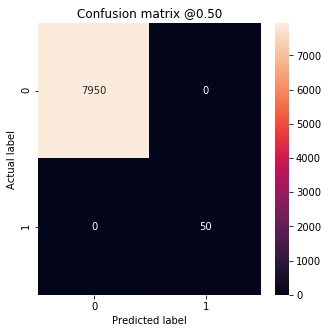

In [287]:
#Evaluate model
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

#### Because training is easier on the balanced data, the above training procedure may overfit quickly. 
#### So break up the epochs to give the `callbacks.EarlyStopping` finer control over when to stop training.

In [288]:
#retrain
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch = 20,
    epochs=10*EPOCHS,
    callbacks = [early_stopping])

Train for 20 steps
Epoch 1/1000
20/20 [==============================] - 2s 105ms/step - loss: 1.1180 - tp: 7847.0000 - fp: 12422.0000 - tn: 8101.0000 - fn: 12590.0000 - accuracy: 0.3894 - precision: 0.3871 - recall: 0.3840 - auc: 0.3438s - loss: 1.1440 - tp: 4805.0000 - fp: 8136.0000 - tn: 5275.0000 - fn: 8408.0000 - accuracy: 0.3786 - precision: 0.3713 - recall: 0.3637 - auc: 0
Epoch 2/1000
20/20 [==============================] - 1s 32ms/step - loss: 0.9584 - tp: 10087.0000 - fp: 11811.0000 - tn: 8589.0000 - fn: 10473.0000 - accuracy: 0.4560 - precision: 0.4606 - recall: 0.4906 - auc: 0.4442
Epoch 3/1000
20/20 [==============================] - 1s 30ms/step - loss: 0.8322 - tp: 11803.0000 - fp: 10912.0000 - tn: 9542.0000 - fn: 8703.0000 - accuracy: 0.5211 - precision: 0.5196 - recall: 0.5756 - auc: 0.5435
Epoch 4/1000
20/20 [==============================] - 1s 33ms/step - loss: 0.7209 - tp: 13389.0000 - fp: 9454.0000 - tn: 11012.0000 - fn: 7105.0000 - accuracy: 0.5957 - precision: 

20/20 [==============================] - 1s 34ms/step - loss: 0.0844 - tp: 20068.0000 - fp: 178.0000 - tn: 20094.0000 - fn: 620.0000 - accuracy: 0.9805 - precision: 0.9912 - recall: 0.9700 - auc: 0.9974
Epoch 38/1000
20/20 [==============================] - 1s 35ms/step - loss: 0.0832 - tp: 19908.0000 - fp: 165.0000 - tn: 20281.0000 - fn: 606.0000 - accuracy: 0.9812 - precision: 0.9918 - recall: 0.9705 - auc: 0.9976
Epoch 39/1000
20/20 [==============================] - 1s 36ms/step - loss: 0.0808 - tp: 20011.0000 - fp: 155.0000 - tn: 20177.0000 - fn: 617.0000 - accuracy: 0.9812 - precision: 0.9923 - recall: 0.9701 - auc: 0.9976
Epoch 40/1000
20/20 [==============================] - 1s 38ms/step - loss: 0.0786 - tp: 19745.0000 - fp: 167.0000 - tn: 20461.0000 - fn: 587.0000 - accuracy: 0.9816 - precision: 0.9916 - recall: 0.9711 - auc: 0.9977
Epoch 41/1000
20/20 [==============================] - 1s 36ms/step - loss: 0.0762 - tp: 20165.0000 - fp: 151.0000 - tn: 20072.0000 - fn: 572.0000

20/20 [==============================] - 1s 33ms/step - loss: 0.0319 - tp: 20231.0000 - fp: 11.0000 - tn: 20574.0000 - fn: 144.0000 - accuracy: 0.9962 - precision: 0.9995 - recall: 0.9929 - auc: 0.9996
Epoch 74/1000
20/20 [==============================] - 1s 36ms/step - loss: 0.0301 - tp: 20354.0000 - fp: 15.0000 - tn: 20475.0000 - fn: 116.0000 - accuracy: 0.9968 - precision: 0.9993 - recall: 0.9943 - auc: 0.9997
Epoch 75/1000
20/20 [==============================] - 1s 37ms/step - loss: 0.0300 - tp: 20221.0000 - fp: 12.0000 - tn: 20607.0000 - fn: 120.0000 - accuracy: 0.9968 - precision: 0.9994 - recall: 0.9941 - auc: 0.9997
Epoch 76/1000
20/20 [==============================] - 1s 32ms/step - loss: 0.0288 - tp: 20286.0000 - fp: 13.0000 - tn: 20537.0000 - fn: 124.0000 - accuracy: 0.9967 - precision: 0.9994 - recall: 0.9939 - auc: 0.9997
Epoch 77/1000
20/20 [==============================] - 1s 37ms/step - loss: 0.0290 - tp: 20178.0000 - fp: 7.0000 - tn: 20659.0000 - fn: 116.0000 - acc

loss :  0.0021000141240656374
tp :  50.0
fp :  0.0
tn :  7950.0
fn :  0.0
accuracy :  1.0
precision :  1.0
recall :  1.0
auc :  0.99999994

Legitimate Transactions Detected (True Negatives):  7950
Legitimate Transactions Incorrectly Detected (False Positives):  0
Fraudulent Transactions Missed (False Negatives):  0
Fraudulent Transactions Detected (True Positives):  50
Total Fraudulent Transactions:  50


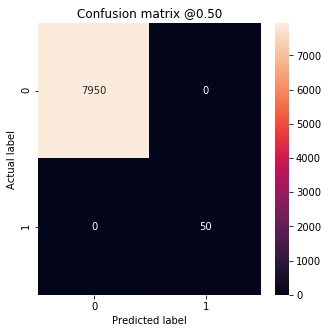

In [289]:
#Evaluate model
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)